<h1 style="text-align: center;">Tennis Analyzer ML Model V2</h1>
<h3 style="text-align: center;">Dan Warnick</h3>

<p>To start we will begin by selecting the data points we want to analyze with existing known results. For each data entry we will have two players each with the following data entries.</p>
<table style="font-size: .8em;">
    <tr>
        <th>Player Name</th>
    </tr>
</table>
<p>Along with match facts like Clay/Hard/Grass Court or Indoor/Outdoor. In the future may want to add weather and adjust certain parameters for more accuracy and more data points to train from, however for now this seems a good start.</p>

<h2>1.) Collect Data Efficiently</h2>

In [1]:
import django
from django.http import HttpResponse
from django.template import loader
import os
from django.db import models
import torch
from math import ceil, floor
import math
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from asgiref.sync import sync_to_async # type: ignore
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import copy
import joblib

# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'breakpoint.settings')
# django.setup()

# from render.models import *

In [2]:
start = '20100101'
end = '20231231'
match_type = 'm'

In [3]:
start_date = datetime.strptime(start, '%Y%m%d').date()
end_date = datetime.strptime(end, '%Y%m%d').date()

# if match_type == 'm':   
#     typer = MensTennisMatch
#     insert_db = MensTennisMatchStats
# else:
#     typer = WomensTennisMatch
#     insert_db = WomensTennisMatchStats

# query = insert_db.objects.filter(
#         tourney_date__range=(start_date, end_date)
#     ).order_by('tourney_date')
    
# games = await sync_to_async(list)(query.all().values())

RD_CUTOFF = 125

df = pd.read_csv('../../testcsvs/StephNRP25.csv')
# df = pd.read_csv('../../testcsvs/GlickoUpdated.csv')
df['tourney_date'] = pd.to_datetime(df['tourney_date']).dt.date
df = df[(df['tourney_date'] >= start_date) & (df['tourney_date'] <= end_date)]
# df = df[(df['a_glicko_rd'] <= RD_CUTOFF) & (df['b_glicko_rd'] <= RD_CUTOFF)]

df = df.drop(['tourney_id', 'tourney_name', 'match_num', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug', 'sets', 'games', 'tiebreaks'], axis=1)
# print(df.duplicated().sum())

# print(len(df))

one_hot_encoder = OneHotEncoder(sparse_output=False)
category_encoded = one_hot_encoder.fit_transform(df[['surface']])
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder.get_feature_names_out(['surface']))

# Concatenate the one-hot encoded columns back to the original DataFrame
df = pd.concat([df.reset_index(drop=True), category_encoded_df], axis=1)

# Drop the original 'category_text' column
df.drop('surface', axis=1, inplace=True)
# print(df.duplicated().sum())

print(len(df))
df.head()

36794


,tourney_date,best_of,tourney_level,tourney_round,a_player_age,a_player_hand,a_player_ht,a_player_rank,a_player_rank_points,b_player_age,...,a_surface_return_second_won_steph_rating,b_surface_second_won_steph_rating,a_surface_return_second_won_steph_rd,b_surface_second_won_steph_rd,a_odds,b_odds,a_b_win,surface_Clay,surface_Grass,surface_Hard
0,2010-01-04,3.0,2.0,0.8,20.0,1.0,183.0,306.0,137.0,31.0,...,2200.0,2200.0,300.0,300.0,NaN,NaN,0.0,0.0,0.0,1.0
1,2010-01-04,3.0,2.0,0.8,28.0,1.0,180.0,104.0,525.0,21.0,...,2200.0,2200.0,300.0,300.0,NaN,NaN,0.0,0.0,0.0,1.0
2,2010-01-04,3.0,2.0,0.8,22.0,1.0,188.0,107.0,516.0,30.0,...,2200.0,2200.0,300.0,300.0,NaN,NaN,1.0,0.0,0.0,1.0
3,2010-01-04,3.0,2.0,0.8,26.0,1.0,180.0,103.0,526.0,28.0,...,2200.0,2200.0,300.0,300.0,NaN,NaN,1.0,0.0,0.0,1.0
4,2010-01-04,3.0,2.0,0.8,25.0,1.0,180.0,38.0,1015.0,33.0,...,2200.0,2200.0,300.0,300.0,NaN,NaN,1.0,0.0,0.0,1.0


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
# class OutcomeProbability(nn.Module):
#     def __init__(self, input_dim=160):
#         hidden_dim1= round ((input_dim + 1) / 2)
#         super(OutcomeProbability, self).__init__()
#         self.hidden = nn.Linear(input_dim, hidden_dim1)
#         self.relu = nn.SiLU()
#         self.bn = nn.BatchNorm1d(hidden_dim1)
#         self.output = nn.Linear(hidden_dim1, 1)
#         self.sigmoid = nn.Sigmoid()
 
#     def forward(self, x):
#         x = self.bn(self.relu(self.hidden(x)))
#         x = self.sigmoid(self.output(x))
#         return x
    
class OutcomeProbability(nn.Module):
    def __init__(self, input_dim=160):
        hidden_dim1= round ((input_dim) / 2)
        hidden_dim2= round ((hidden_dim1) / 2)
        super(OutcomeProbability, self).__init__()
        self.dropout = nn.Dropout(0.33)
        self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu1 = nn.SiLU()
        self.relu2 = nn.SiLU()
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.output = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.dropout(x)
        x = self.bn1(self.relu1(self.hidden1(x)))
        x = self.bn2(self.relu2(self.hidden2(x)))
        x = self.sigmoid(self.output(x))
        return x
    
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.33)
        self.shortcut = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn(self.fc(x)))
        x = self.dropout(x)
        return x + residual

class OutcomeProbabilityV6(nn.Module):
    def __init__(self, input_dim=172, dropout_prob=0.33):
        hidden_dim1=input_dim * 2
        hidden_dim2=input_dim
        hidden_dim3=round(input_dim/2) 
        super(OutcomeProbabilityV6, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.res_block1 = ResidualBlock(hidden_dim1, hidden_dim1)
        self.res_block2 = ResidualBlock(hidden_dim1, hidden_dim2)
        self.res_block3 = ResidualBlock(hidden_dim2, hidden_dim3)
        
        self.fc4 = nn.Linear(hidden_dim3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.sigmoid(self.fc4(x))
        return x

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=160):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.SiLU() #hehe
        self.sigmoid = nn.Sigmoid()
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  # Softmax is applied in the loss function
        return x
    

In [6]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss_fn = nn.BCELoss()  # binary cross entropy
    loss_fn = nn.BCEWithLogitsLoss()  # binary cross entropy

    optimal_lr = .001
    optimizer = optim.Adam(model.parameters(), lr=optimal_lr)
    # optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Parameters for learning rate warmup
    warmup_epochs = 5
    total_epochs = 300
    batch_size = 32
    batch_start = torch.arange(0, len(X_train), batch_size)
    
    # Set up learning rate scheduler (StepLR after warm-up)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    # Hold the best model
    best_acc = -np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(total_epochs):
        # Warm-up phase: linearly increase learning rate
        if epoch < warmup_epochs:
            # print(optimizer.param_groups[0]['lr'])
            lr = optimal_lr * (epoch + 1) / warmup_epochs
            # print(lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # Take a batch
                X_batch = X_train[start:start + batch_size]
                y_batch = y_train[start:start + batch_size]
                # Forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                # Update weights
                optimizer.step()
                # Print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )

        # Evaluate accuracy at the end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            print(f"Accuracy: {acc}")
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        
        # Apply scheduler after warm-up period
        if epoch >= warmup_epochs:
            scheduler.step()

        # print(optimizer.param_groups[0]['lr'])

    # Restore model with the best weights and return the best accuracy
    model.load_state_dict(best_weights)
    return best_acc


Accuracy: 0.6039982438087463
Accuracy: 0.6091430187225342
Accuracy: 0.623695433139801
Accuracy: 0.6267822980880737
Accuracy: 0.6294282078742981
Accuracy: 0.6295751929283142
Accuracy: 0.6341320276260376
Final model accuracy: 63.41%


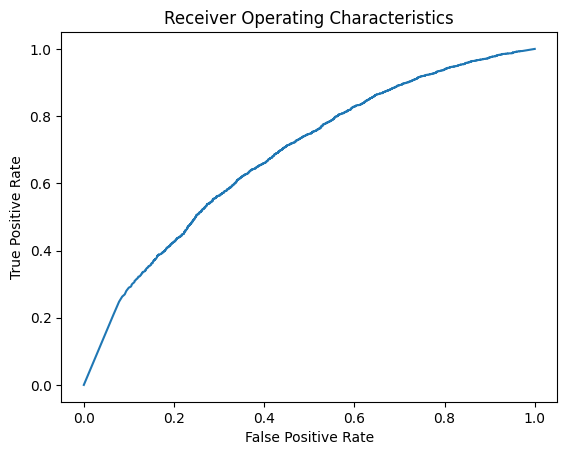

In [7]:
df = df.dropna()
# print(len(df))

# Extract relevant columns for odds and index
odds_df = df[['a_odds', 'b_odds']].copy()
odds_df['index'] = df.index

# Drop odds columns from the main dataframe
df = df.drop(columns=['a_odds', 'b_odds'])

# Extract target variable `y` and features `X`
y = df['a_b_win'].values
X = df.drop('a_b_win', axis=1)

# Ensure the 'tourney_date' column is in datetime format
X['tourney_date'] = pd.to_datetime(X['tourney_date'])

# Define the date ranges for training and testing
train_start_date = "2012-01-01"
train_end_date = "2016-12-31"
test_start_date = "2017-01-01"
test_end_date = "2019-12-31"

# Filter the data for training and testing based on the date range
train_mask = (X['tourney_date'] >= train_start_date) & (X['tourney_date'] <= train_end_date)
test_mask = (X['tourney_date'] >= test_start_date) & (X['tourney_date'] <= test_end_date)

# Create training and testing sets
X_train = X.loc[train_mask].drop(columns=['tourney_date']).values  # Drop the 'tourney_date' column if not needed for training
y_train = y[train_mask]
idx_train = odds_df.loc[train_mask, 'index'].values

X_test = X.loc[test_mask].drop(columns=['tourney_date']).values  # Drop the 'tourney_date' column if not needed for testing
y_test = y[test_mask]
idx_test = odds_df.loc[test_mask, 'index'].values

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Make sure y_train has the correct shape
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure y_test has the correct shape



# print(len(X.columns))
model = OutcomeProbabilityV6(len(X.columns)-1) #For date removal
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")
 
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        # print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [8]:
# Kelly Criterion
def kelly_criterion(vegas_odds, calculated_probability):
    corrected = vegas_odds - 1
    # Calculate the Kelly fraction
    kelly_fraction = calculated_probability - ((1 - calculated_probability)/corrected)
    # Ensure that the fraction is not negative
    kelly_fraction = max(0, kelly_fraction)
    
    return kelly_fraction

In [9]:
better = 0
total_won = 0
diff_fav = 0
bet_correct = 0

upset_predict = 0
upset_correct = 0
upset_won = 0

model_correct = 0
vegas_correct = 0
vegas_total = 0

wrong = 0
comparison_df = results_df.dropna()
length = len(comparison_df)

avg_bet = 0

confidence_pct = .5
confidence_top_pct = 1

START_UNIT = 10
UNIT = START_UNIT

for i, row in comparison_df.iterrows():
    current = START_UNIT
    if confidence_top_pct > row['Predicted'] > confidence_pct :
        kelly = (kelly_criterion(row['A_Odds'], row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(row['A_Odds'], row['Predicted'])
        if(row['Actual'] == 1):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (row['A_Odds']-1) * kelly
        else:
            wrong += 1 if kelly > 0 else 0
            START_UNIT -= kelly

    if 1-confidence_top_pct < row['Predicted'] < 1-confidence_pct :
        kelly = (kelly_criterion(row['B_Odds'], 1-row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(row['B_Odds'], 1-row['Predicted'])
        if(row['Actual'] == 0):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (row['B_Odds']-1) * kelly
        else:
            wrong += 1 if kelly > 0 else 0
            START_UNIT -= kelly

    if round(row['Predicted']) != round(1/row['A_Odds']):
        kelly_A  = (kelly_criterion(row['A_Odds'],row['Predicted']) * UNIT)
        kelly_B  = (kelly_criterion(row['B_Odds'],1-row['Predicted']) * UNIT)

        upset_predict += 1 if (kelly_A > 0 and round(row['Predicted']) == 1) or (kelly_B > 0 and round(row['Predicted']) == 0) else 0

        if round(row['Predicted']) == round(row['Actual']):
            if(row['Actual'] == 1):
                upset_correct += 1 if kelly_A > 0 else 0
                upset_won += (row['A_Odds']-1) * kelly_A
            else:
                upset_correct += 1 if kelly_B > 0 else 0
                upset_won += (row['B_Odds']-1) * kelly_B
        elif round(row['Predicted']) == 1:
            upset_won -= kelly_A
        else:
            upset_won -= kelly_B
            
    if round(row['Predicted']) != round(1/row['A_Odds']):
        diff_fav += 1

    if row['Actual']==1 and row['A_Odds'] < row['B_Odds']:
        # print(f"A odds : {row['a_odds']} B odds : {row['b_odds']}")
        vegas_correct += 1

    if row['Actual']==0 and row['A_Odds'] > row['B_Odds']:
        vegas_correct += 1

    if round(row['Predicted']) == round(row['Actual']):
        model_correct += 1


print(f"Total returned on Starting ${UNIT} bankroll: {START_UNIT:.2f} on a total # bets: {better} from a total of {length} games")
print(f"ROI : {((START_UNIT-UNIT)/UNIT):.1f} X")
print(f"Avg Bankroll Bet % : {(avg_bet/better):.3f} %")
print(f"Amount of differing favorites %: {(diff_fav/length):.3f}")
print(f"Amount of upset bets correct % : {(upset_correct/upset_predict):.3f} with Unit ${UNIT} won ${upset_won:.2f} on {upset_predict} bets")
print(f"Amount of incorrect bet % : {(wrong/better):.4f}")
print(f"Correct Bet %: {(bet_correct/better):.4f}")
print(f"Model % Correct : {(model_correct/length):.4f} Vegas Correct % : {(vegas_correct/length):.4f}")


NameError: name 'results_df' is not defined